# The United States Top 1,000 Contiguous State City-Pair Markets

The data used in the capstone project is about domestic airlines of the United States from US Department of Transportation. It mainly covers the 1,000 largest city-pair markets in the 48 contiguous states. For each of the 1,000 largest city-pair markets, the dataframe lists the number of one-way passenger trips per day, the nonstop distance, the average market fare, and identifies the airlines with the largest market share and the lowest average fare; market share and average fares are provided for both airlines. 

In this project, I plan to see the frequency of each airline either with the largest market share or the lowest average fare. I hope to see which airlines have the largest market share and which have the lowest average fare, and check if there will be some airlines that can take both the largest average market share and lowest-fare-competing market. In addition, I want to focus on some major carriers, to see their change on frequency, market share, and average fare by time for both dominant airlines and lowest-cost competing airlines.

## Data ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
import statsmodels.formula.api as smf
from YIYU_FU_Module import end_day,lg_count_sort,low_count_sort,bar_freq,plot_carrier_major_freq,bar_carrier_major_ms,plot_carrier_major_ms,bar_carrier_major_fare,plot_carrier_major_fare,lmplot_lg_fare_ms,lmplot_low_fare_ms

In [2]:
df_url = 'https://data.transportation.gov/api/views/4f3n-jbg2/rows.csv?accessType=DOWNLOAD'
df =  pd.read_csv(df_url,dtype={'citymarketid_1':object,'citymarketid_2':object})

In [3]:
# Drop some variables not to be used
df = df.drop(columns=['table_1_flag','Geocoded_City1','Geocoded_City2'])
# Add a date variable to draw time series plot later
df['date']=df['Year'].astype(str)+df['quarter'].astype(str).str.zfill(2)
df['date']=df['date'].apply(lambda x: end_day(x))
# Check variable types
print(df.dtypes)
# Have a look of the whole dataset
df.head()

Year                       int64
quarter                    int64
citymarketid_1            object
citymarketid_2            object
city1                     object
city2                     object
nsmiles                    int64
passengers                 int64
fare                     float64
carrier_lg                object
large_ms                 float64
fare_lg                  float64
carrier_low               object
lf_ms                    float64
fare_low                 float64
date              datetime64[ns]
dtype: object


,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,date
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,2009-06-30
1,2000,4,30397,33198,"Atlanta, GA (Metropolitan Area)","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,2000-12-31
2,2007,4,32575,34614,"Los Angeles, CA (Metropolitan Area)","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,2007-12-31
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis/St. Paul, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,2004-12-31
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,2008-12-31


In [4]:
# A general description of the whole dataset
df.describe(include = 'all')

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,date
count,90021.000000,90021.00000,90021,90021,90021,90021,90021.000000,90021.000000,90021.000000,90021,90021.000000,90021.000000,90018,90018.000000,90018.000000,90021
unique,NaN,NaN,139,127,139,127,NaN,NaN,NaN,43,NaN,NaN,53,NaN,NaN,90
top,NaN,NaN,30397,30852,"Atlanta, GA (Metropolitan Area)","Washington, DC (Metropolitan Area)",NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,1996-12-31 00:00:00
freq,NaN,NaN,5236,6183,5236,6183,NaN,NaN,NaN,23639,NaN,NaN,29666,NaN,NaN,1002
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-03-31 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 00:00:00
mean,2006.766288,2.48893,NaN,NaN,NaN,NaN,1052.714722,802.367559,193.183622,NaN,0.552631,197.365244,NaN,0.321776,164.393750,NaN
std,6.516946,1.11803,NaN,NaN,NaN,NaN,613.943630,1290.325158,61.662611,NaN,0.187122,71.190189,NaN,0.241169,55.883856,NaN
min,1996.000000,1.00000,NaN,NaN,NaN,NaN,109.000000,110.000000,56.420000,NaN,0.020000,51.490000,NaN,0.010000,51.490000,NaN
25%,2001.000000,1.00000,NaN,NaN,NaN,NaN,577.000000,235.000000,148.110000,NaN,0.410000,144.750000,NaN,0.140000,122.392500,NaN


Here is a general description of our dataset. We can see that there are totally 90021 records in the dataset, from 1996 to 2018.
<br>
**The categorical variables include:**
<br>
*citymarketid_1/citymarketid_2* --  an identification number assigned by US DOT to identify a city market, 
<br>
*city1/city2* -- consolidate airports serving the same city market, 
<br>
*carrier_lg* -- Carrier with the largest market share, 
<br>
*carrier_low* -- Carrier with the lowest fare
<br>
**The numerical variables include:**
<br>
*nsmiles* -- Non-Stop market miles
<br>
*passengers* -- Passenger per day
<br>
*fare* -- Overall average fare
<br>
*large_ms* -- Market share for the carrier with the largest market share
<br>
*fare_lg* -- Average fare for the carrier with the largest market share
<br>
*lf_ms* -- Market share for the carrier with the lowest average fare
<br>
*fare_low* -- Average fare for the carrier with the lowest average fare

For the categorical variables, both the most freqeuent carrier with the largest market share and lowest average fare is **WN** which occurs in 23639 and 29666 records respectively. The most frequent city 1 is Atlanta, GA (city id: 30397) occupying 5236 records, and the most frequent city 2 is Washington, DC(city id: 30852) occupying 6183 records.



## Figure out missing values and duplicated records

In [5]:
# Check missing values in the dataset
df_missing =df.isna()
# print(df_missing.dtypes) # the data in df_missing are all boolean data type, thus every single value in the entire s either True or False
# print()
# Sum boolean dataframe (Booleans are treated as numeric when doing arithmetic peration. True = 1, False = 0)
num_missing = df_missing.sum() #by default sum each column independently, and returns the number of values that are True
                                #The True values here represent missing values in our original dataframe.
                                #number of missing values in each column
# turn the results into percentage(divide each value in the Series by the number of rows)    
print('The percentage missing value in each column:')
print(num_missing/len(df))

# Then we delete records including the missing values 
df = df.dropna()
print()

# Check if there is any duplicated rows in data
record_dup = df[df.duplicated()].shape[0]
print(f'The number of duplicated records is: {record_dup}')

The percentage missing value in each column:
Year              0.000000
quarter           0.000000
citymarketid_1    0.000000
citymarketid_2    0.000000
city1             0.000000
city2             0.000000
nsmiles           0.000000
passengers        0.000000
fare              0.000000
carrier_lg        0.000000
large_ms          0.000000
fare_lg           0.000000
carrier_low       0.000033
lf_ms             0.000033
fare_low          0.000033
date              0.000000
dtype: float64

The number of duplicated records is: 0


The missing values in columns **_carrier_low, lf_ms, fare_low_** only count for 0.0033%, which is a very small percentage among the whole data, thus I plan to delete the rows with missing values directly. 

In addition, no duplicated record is found. Therefore, we do not need to delete more rows.

## Exploratory Data Analysis

In [6]:
# Unique carriers for carriers with the largest market and carriers with the lowest average fare
carrier_lg = df['carrier_lg'].unique()
carrier_low = df['carrier_low'].unique()
# Common carriers 
print('Common carriers for carriers with the largest market and carriers with the lowest average fare:')
print(np.intersect1d(carrier_lg,carrier_low))
# Excluded carriers 
print('Carriers with the largest market share not included in carriers with the largest market share:')
print(np.setdiff1d(carrier_lg,carrier_low))
print## Exploratory Data Analysis('Carriers with the lowest average fare not included in carriers with the largest market share:')
print(np.setdiff1d(carrier_low,carrier_lg))  

Common carriers for carriers with the largest market and carriers with the lowest average fare:
['9N' 'A7' 'AA' 'AS' 'B6' 'CO' 'DH' 'DL' 'F9' 'FL' 'G4' 'HP' 'J7' 'JI'
 'KP' 'KW' 'N7' 'NJ' 'NK' 'NW' 'PN' 'QQ' 'QX' 'RP' 'RU' 'SX' 'SY' 'T3'
 'TW' 'TZ' 'U5' 'UA' 'US' 'VX' 'W7' 'W9' 'WN' 'WV' 'YV' 'YX' 'ZA' 'ZW']
Carriers with the largest market share not included in carriers with the largest market share:
['XJ']
Carriers with the lowest average fare not included in carriers with the largest market share:
['AQ' 'E9' 'EV' 'FF' 'L4' 'N5' 'OE' 'OO' 'P9' 'SM' 'TB']


### Seperate frequency of carriers with largest maket share and lowest average fare

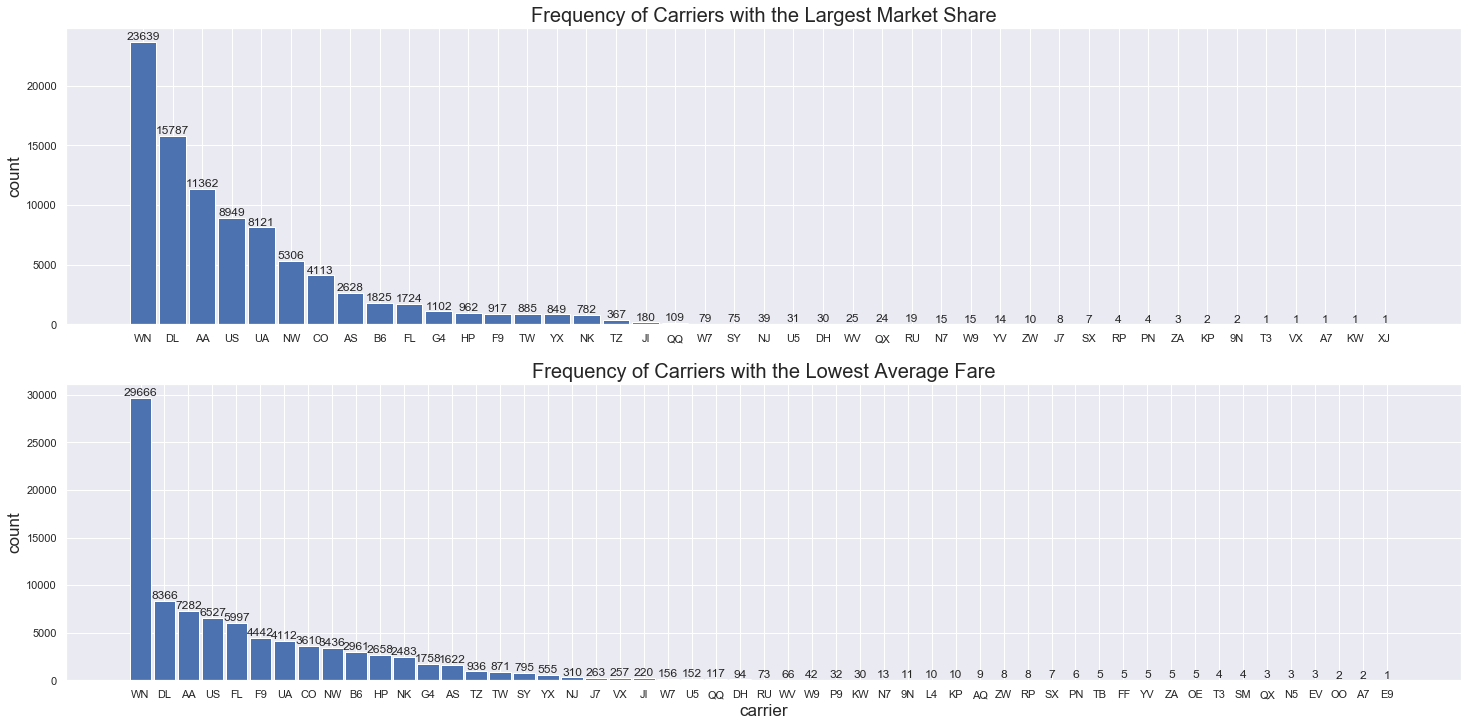

In [7]:
sns.set(style="darkgrid")
# Group the number of carriers in descending order
carrier_lg_count_sort = lg_count_sort(df)
carrier_low_count_sort = low_count_sort(df)
# plot frequency of carriers 
bar_freq(carrier_lg_count_sort,carrier_low_count_sort)

I firstly have an overview of carriers' frequency from 1996 to 2018. The higher the frequency indicates that this airline is more widely applied in different markets. The above bar plots demonstrate the frequency of each ariline applied in domestic markets, respectively for carriers of the largest market share, carriers of the lowest fare, and carriers which are both largest market share and lowest fare in each city-pair market. 

From the above bar plots, we can see that **WN, DL, AA, US** are most widely applied in domestic markets. Whatever for the carriers with the largest market share or for carriers with the lowest average fare, They are always the top four in the same sequence. **WN** airline, whose occurence is far more than that of other airlines, is especially noticeable. WN airline is more than 3 times(29666) the 2nd most frequently used carrier DL(8366) in lowest-fare carriers, and more than 6 times(14462) the 2nd most frequently used carrier US(2236) in carriers in dominant carriers. 

In the following analysis, I will focus on the top 4 frequent carriers--WN, DL, AA, US--to do further analysis.

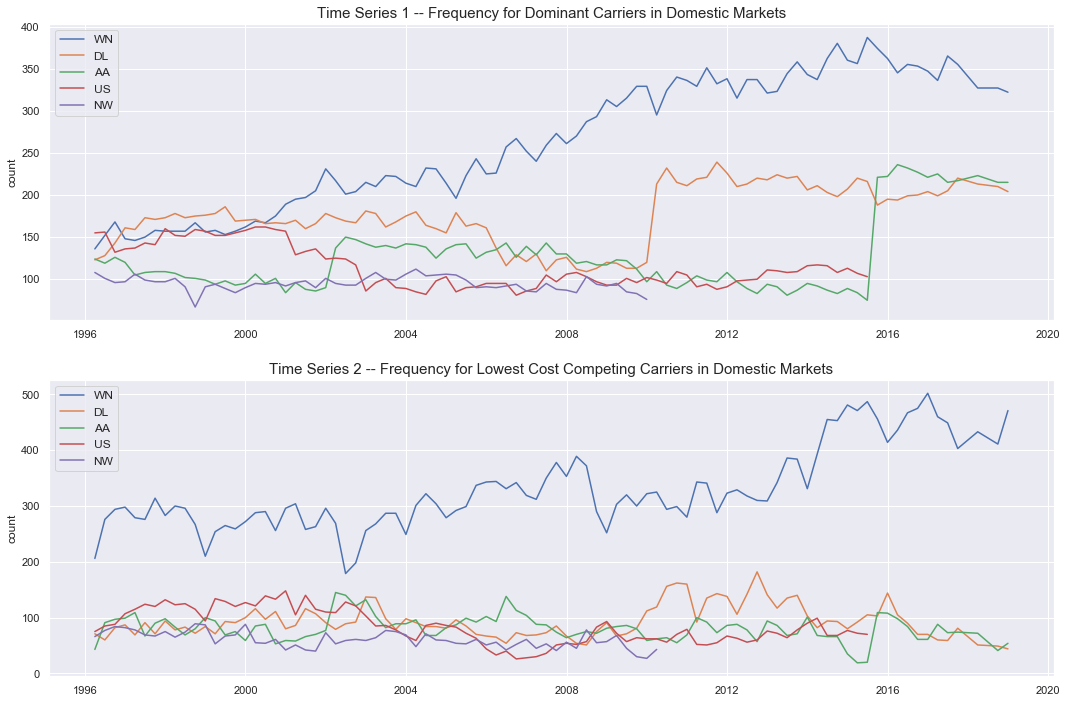

In [8]:
register_matplotlib_converters()
plot_carrier_major_freq(df)

The above two time series show the frequency of the selected four carriers and NW carrier when they are dominant carriers and lowest-cost-competing carriers. From time series 1, we can see that the frequency of DL carrier has a significant increase in dominant carriers around the end of 2009 and the beginning of 2010. It is known that DL was merged with NW on December 31, 2009, and the merged carrier continued to use Delta as its carrier name. That is why I add NW into the major carriers analysis, to see its change before merger. From the above plots, we can see that there is no more record for NW after 2009. Similar situation is for US and AA that US's records stopped by quarter 2 in 2015. AA and US publicly merged on October 17, 2015, and continue to operate as the name of American Airline. Above time series 1 shows AA has significantly increase in frequency as dominant carrier after that time.

In addition, we still need to have an eye on WN airline. WN keeps taking the advantage as lowest cost competing carrier, because its frequency is always much higher than the other four carriers and even has an increasing trend in time series 2. In comparison, the other carriers' frequencies do not have obvious trend. Furthermore, in time series 1, even though WN did not have frequency advantage at the beginnig of the duration from 1996 to 2000, WN becomes the most frequent carrier after that among carriers with the largest market share in their markets. Also, the increasing speed for the frequency of WN is quite quick as a dominant carrier. 

### Average market share for carriers with the largest market share and lowest average fare

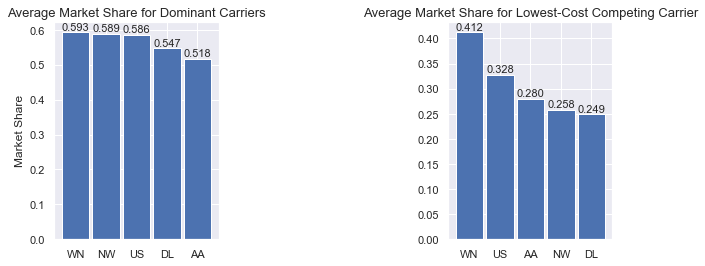

In [9]:
bar_carrier_major_ms(df)

Whatever for carriers with the largest market share and carriers with the lowest market share, WN always have the highest average market share 59.3%. For dominant carriers, we can see that the market shares of the five carriers are very close and are all more than 50%, especially for WN, NW and US which have very close market share. 
<br>
When they play as carriers with the lowest average fare in their market, WN is still of the highest average market share with 41.2%, compared to the other three major airlines. 
<br>

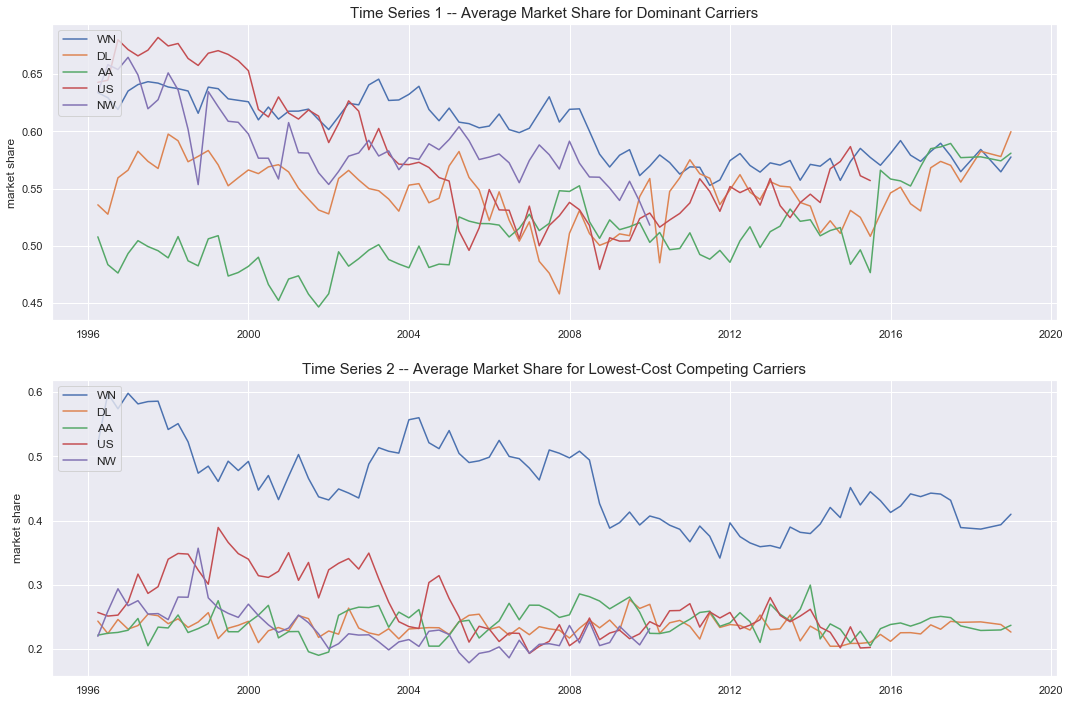

In [10]:
plot_carrier_major_ms(df)

For the market share time series, we can see the average market share for WN is decreasing whenever as a dominant market or lowest-cost competing market. Among dominant carriers, WN is gradually not the distinguished one in average market share compared to the others, and average market shares of DL and AA start to surpass that of WN in recent years.
<br>
Nevertheless, WN is still of superb largest market share among carriers with the lowest average fee, in spite of its decline trend these years.
<br>
Gnerally, we can say that WN has an outstanding market share performance whenver as a dominant carrier or low-cost-competing carrier most time. However, in recent years, WN's market share does not have a significant advantage among dominant airlines.
<br>
It is noticeable that average market share of DL does not have an instant obvious increase after its merging with NW at the end of 2009. Among dominant carriers, average market share of DL starts to show a relatively stable increasing trend since 2015 and exceeds WN from the third quarter of 2018. By contrast, in dominant carriers, average market share of AA did have an instant obvious increase in the 3rd quarter of 2015 after merging with US. Additionally, merge seems do not have any effect on average market share of DL and AA as lowest fare carriers in markets.

### Average fare for carriers with the largest market share and lowest average fare

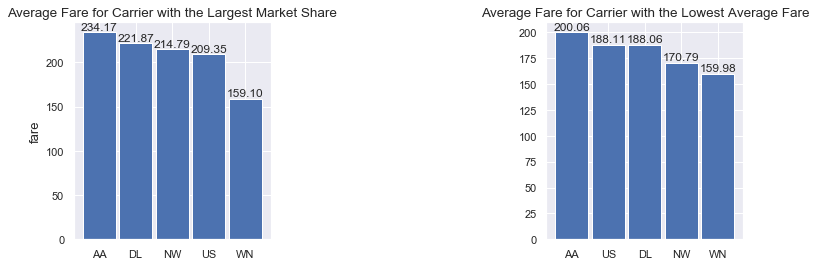

In [11]:
bar_carrier_major_fare(df)

Different from frequency and market share data, the average fare of WN is the lowest of the five popular carriers whenever among dominant carriers or among lowest-cost-competing carriers. As a dominant carrier, WN's average fare only has 159.10, which has a large gap with other carriers. Other four carriers' average fares are very close, and the average fare of them are all more than $200. 
<br>
It is interesting that the average fare for WN as a dominant carrier is even less than that for WN as a lowest-fare competing carrier. This indicates that less fare may earn more market share for WN.

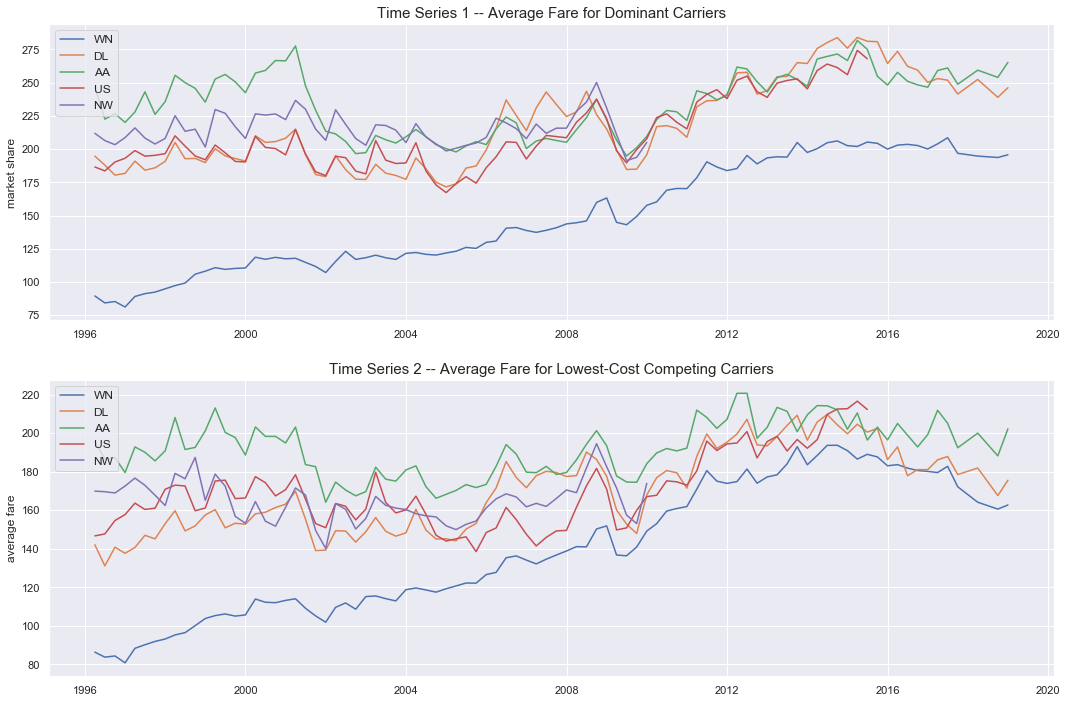

In [12]:
plot_carrier_major_fare(df)

The average fare of WN is almost always the lowest among both dominant carriers and low-cost-competing carriers. However, it keeps increasing in these years, and becomes very close to the average fare of other carriers as lowest-cost competing carriers. 
<BR>
The two mergings between DL and NW and between AA and US seem do not have much effect on the average fare. The average fare of DL and AA almost keep the same steps in changing by time.

### Relationship between fare and market share

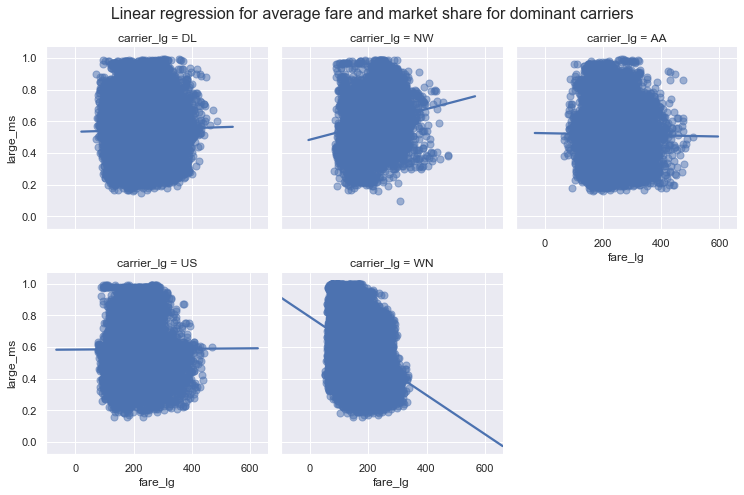

In [13]:
lmplot_lg_fare_ms(df)

As carriers of the largest average market share, the average fare for DL, AA and US nearly will not change as the increase or decrease of average fare. However, average fare of NW has a lightly positive relationship with its average market share. Furthermore, for WN, its average market share will crucially decrease as its average fare increase.  

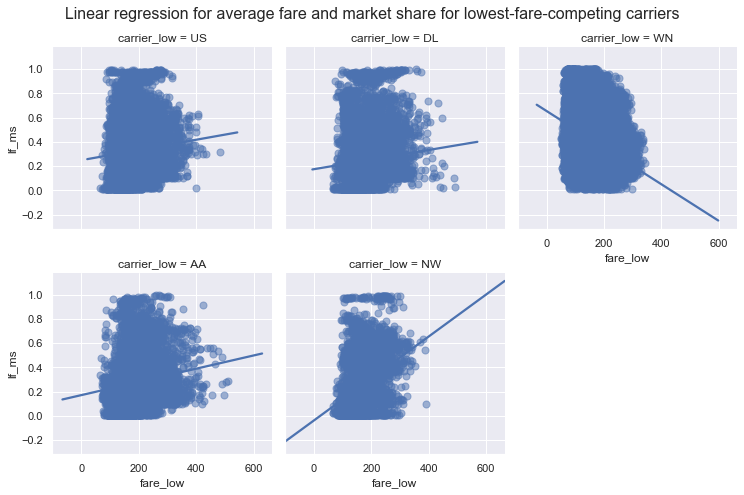

In [14]:
lmplot_low_fare_ms(df)

When they are carriers of the lowest average fare, all of them show positive relationship between average fare and average market share in exception of WN. The average fare of WN still negatively related to its average market share. 


The negative correlation between fare and market share of WN correponds to my suppose before.

In [31]:
df_pas_fare = df.groupby(['date'])['passengers','fare'].mean().reset_index()


Text(0.5, 1.0, 'Time Series -- Average Passengers each quarter')

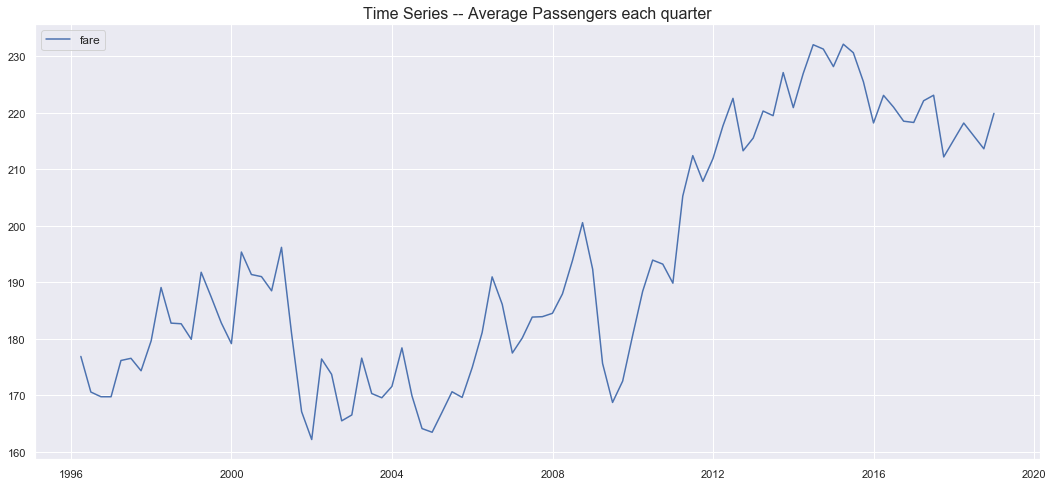

In [37]:
plt.figure(figsize=(18,8))
# plt.plot(df_pas_fare['date'],df_pas_fare['passengers'],label='passengers')
plt.plot(df_pas_fare['date'],df_pas_fare['fare'],label='fare')
# plt.ylabel('passengers') 
plt.legend(loc=2,fontsize=12) 
plt.title('Time Series -- Average Passengers each quarter', fontsize = 16)

## Predictive Analytics

In [545]:
df_WN_lg_major = df_carrier_lg_major.loc[df_carrier_lg_major['carrier_lg'] == 'WN']

In [546]:
results_1 = smf.ols('large_ms ~ fare_lg', data = df_WN_lg_major).fit()
print(results_1.params)
results_1.summary()

Intercept    0.789033
fare_lg     -0.001232
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               large_ms   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     3519.
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:26:52   Log-Likelihood:                 8036.8
No. Observations:               23639   AIC:                        -1.607e+04
Df Residuals:                   23637   BIC:                        -1.605e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7890      0.003    226.163      0.000       0.782       0.796
fare_lg       -0.0012   2.08e-05    -59.323      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     1487.606   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              563.583
Skew:                           0.096   Prob(JB):                    4.16e-123
Kurtosis:                       2.268   Cond. No.                         523.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I try to see if there is any obvious linear relationship between average fare and passengers for WN as a dominant carrier. From the above OLS linear regression model, the R-square value is very small with only 0.13. Therefore, this is not a good model to predict market share of WN based on its average fare as a dominant carrier. Other variables is needed to be considered to forecast the market share of WN, such as passengers, city-pair market, etc.